In [1]:
# %pip install --upgrade pingouin
%pip install pyvttbl


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.spatial import distance
from IPython.display import display
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
# import pyvttbl as pt
# OG_DATA_PATH = './TaskPerformance/'
OG_DATA_PATH = './MatData/'
PLOTS_PATH = './Sabine_poster/map/'
DATA_PATH = './AllData/'
PROCESSED_DATA_PATH = './csv_files/'
os.makedirs(os.path.dirname(PLOTS_PATH), exist_ok=True)
os.makedirs(os.path.dirname(DATA_PATH), exist_ok=True)
sns.set(context = "poster", style="white", palette="dark", font_scale=2, rc={'figure.figsize':(12,9)})

In [3]:
# Check valid subjects
subdf = pd.read_csv('./Seahaven_alignment_project_24092019.csv', sep=';')
display(subdf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 17 columns):
Date                527 non-null object
Experimenter        527 non-null object
Subject             527 non-null object
Measurement         527 non-null int64
Training            527 non-null object
Repeated            337 non-null object
Discarded           85 non-null object
Folder Name/link    523 non-null object
Testvers            496 non-null object
Comments            284 non-null object
Unnamed: 10         55 non-null object
Unnamed: 11         23 non-null object
Unnamed: 12         15 non-null object
Unnamed: 13         3 non-null object
Unnamed: 14         2 non-null object
Unnamed: 15         1 non-null float64
Unnamed: 16         1 non-null object
dtypes: float64(1), int64(1), object(15)
memory usage: 70.1+ KB


None

In [4]:
housedf = pd.read_csv(DATA_PATH + 'complete_list_houses.txt',header=None) 
house_coords = pd.read_csv(DATA_PATH + 'HouseList.txt',header=None)
housedf.columns=['HouseNr_Angle']
house_coords.columns = ['HouseNr_coordinates']
housedf = housedf.HouseNr_Angle.str.split('_', expand=True)
housedf.columns=['HouseNr', 'Angle']
housedf.set_index('HouseNr', inplace=True)
house_coords = house_coords.HouseNr_coordinates.str.split(':', expand=True)
house_coords.columns = ['HouseNr', 'coordinates']
house_coords[['x','y']] = house_coords.coordinates.str.split(';', expand=True)
house_coords.set_index('HouseNr', inplace=True)

housedf = housedf.merge(house_coords, on='HouseNr')
housedf.drop(columns='coordinates', inplace=True)

housedf = housedf.reset_index()
housedf.HouseNr.str.strip()
housedf.Angle.str.strip()
housedf.x.str.strip()
housedf.y.str.strip()
housedf = housedf.astype(np.float64)
display(housedf.head())

housedf.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_house_info.csv', index=False)

,HouseNr,Angle,x,y
0,1.0,90.0,418.0,710.7
1,2.0,180.0,419.1,725.3
2,3.0,180.0,419.2,750.2
3,5.0,180.0,463.9,784.7
4,6.0,180.0,400.9,835.7


In [5]:
maptmpdf = (
    subdf
    .query('Discarded != "yes"')
    .query('Measurement == 3')
    .query('Training == "map"')
    [['Subject']] 
)
VRtmpdf = (
    subdf
    .query('Discarded != "yes"')
    .query('Measurement == 3')
    .query('Training == "VR"')
    [['Subject']] 
)
map_val_subs = maptmpdf.Subject.unique()  
VR_val_subs = VRtmpdf.Subject.unique()
display(map_val_subs)
display(VR_val_subs)

array(['1719', '2096', '2294', '2299', '2557', '3426', '4199', '4749',
       '5048', '5162', '5904', '6449', '7085', '7396', '7844', '8021',
       '8078', '8124', '8479', '8802', '9369', '9864'], dtype=object)

array(['1089', '1155', '2044', '3023', '3743', '4272', '5239', '5253',
       '5346', '6398', '7021', '8072', '8195', '8261', '8547', '8699',
       '8936', '8954', '9017', '9437', '9475', '9961'], dtype=object)

In [6]:
def mat_to_df(subNr,taskType):
    '''
    converts mat struct with task results into pandas df
    also adds extra column with information whether trial was correct or wrong    
    '''
    columns = {'Absolute': ['HouseNr', 'Correct_Angle', 'Wrong_Angle', 'Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject'],
               
               'Relative': ['PrimeNr', 'TargetNr_correct', 'TargetNr_wrong', 'Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject'],
               
               'Pointing': ['PrimeNr', 'TargetNr', 'Angle_correct', 'Angle_wrong','Correct_Answer','RT',
               'Sub_Answer', 'Accurate', 'Time', 'Task', 'Subject']
              }
    matpath = OG_DATA_PATH+"/AlignmentVR_SubjNo_"+ str(subNr) +".mat"
    if os.path.exists(matpath):
        mat_contents = spio.loadmat(matpath)
        type_array = []
        for j,cond_2 in enumerate(["Trial_3s", "Trial_Inf"]):
            trials_array = []
            for line in range(len(mat_contents['Output'][0][0][taskType][cond_2][0][0])):
                value_array = []
                for column in range(len(mat_contents['Output'][0][0][taskType][cond_2][0][0][line][0])):
                    value = mat_contents['Output'][0][0][taskType][cond_2][0][0][line][0][column][0][0]
                    value_array.append(value)
                # check if trial is correct(true or false
                value_array.append(value_array[-1] == value_array[-3])
                value_array.extend([cond_2.split('_')[1],taskType, subNr]) 
    #                 print(value_array)
                trials_array.append(value_array)
    #             print(len(value_array))
            type_array.extend(trials_array)
    #     print(type_array)
        return pd.DataFrame.from_records(type_array, columns=columns[taskType])
    else:
        print(matpath+' NOT FOUND!')
        return pd.DataFrame()

In [7]:
abs_df = pd.concat([mat_to_df(sub, 'Absolute') for idx, sub in enumerate(map_val_subs)],
            ignore_index=True) 
abs_df['AngularDiff'] = abs(abs_df.Correct_Angle - abs_df.Wrong_Angle)
abs_df.loc[abs_df['AngularDiff']>180, 'AngularDiff' ] = 360 - abs_df['AngularDiff']
abs_df['AngularDiff'] = abs_df['AngularDiff'].astype(str)

abs_df['Correct_Angle_180'] = abs_df.Correct_Angle
abs_df.loc[abs_df['Correct_Angle_180']>180, 'Correct_Angle_180' ] = 360 - abs_df['Correct_Angle_180']
# display(abs_df.Correct_Angle_180.value_counts(bins=7))
# bins = pd.IntervalIndex.from_tuples([(0, 10), (15, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,15,45,75,105,135,165,195]
abs_df['AngleToNorth'], bins = pd.cut(abs_df.Correct_Angle_180, bins=7,labels=[0,30,60,90,120,150,180], retbins=True)
display(abs_df.AngleToNorth.value_counts())

150    286
90     264
60     264
120    242
30     242
180    154
0      132
Name: AngleToNorth, dtype: int64

In [8]:
rel_df = pd.concat([mat_to_df(sub, 'Relative') for idx, sub in enumerate(map_val_subs)],
            ignore_index=True) 

rel_df['Correct_Angle'] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')['Angle']
rel_df['Wrong_Angle'] = rel_df.merge(housedf, left_on='TargetNr_wrong', right_on='HouseNr', how='left')['Angle']
rel_df['AngularDiff'] = abs(rel_df.Correct_Angle - rel_df.Wrong_Angle)
rel_df.loc[rel_df['AngularDiff']>180, 'AngularDiff' ] = 360 - rel_df['AngularDiff']

# bins = pd.IntervalIndex.from_tuples([(0, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,45,75,105,135,165,195]
rel_df['AngularDiff'] = pd.cut(rel_df.AngularDiff, bins=bins,labels=[30,60,90,120,150,180], retbins=False)

rel_df['AngularDiff'] = rel_df['AngularDiff'].astype(str)

display(rel_df.AngularDiff.value_counts())
display(rel_df.head())

120    264
60     264
180    264
90     264
30     264
150    264
Name: AngularDiff, dtype: int64

,PrimeNr,TargetNr_correct,TargetNr_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,Correct_Angle,Wrong_Angle,AngularDiff
0,171,147,88,D,2.398472,D,True,3s,Relative,1719,63.0,90.0,30
1,189,190,19,U,2.487582,U,True,3s,Relative,1719,60.0,180.0,120
2,117,110,53,U,2.156479,D,False,3s,Relative,1719,30.0,90.0,60
3,180,169,125,D,1.408578,D,True,3s,Relative,1719,325.0,125.0,150
4,55,50,85,D,1.669780,U,False,3s,Relative,1719,90.0,270.0,180


In [9]:
point_df = pd.concat([mat_to_df(sub, 'Pointing') for idx, sub in enumerate(map_val_subs)],
            ignore_index=True) 
point_df['AngularDiff'] = abs(point_df.Angle_correct - point_df.Angle_wrong)
point_df.loc[point_df['AngularDiff']>180, 'AngularDiff' ] = 360 - point_df['AngularDiff']

point_df['AngularDiff'] = point_df['AngularDiff'].astype(str)

display(point_df.AngularDiff.value_counts())

120    264
60     264
180    264
90     264
30     264
150    264
Name: AngularDiff, dtype: int64

In [10]:
map_perf_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
map_perf_df['Group'] = 'Map'
display(map_perf_df.head())

,Subject,Task,Time,Accuracy,Group
0,1719,Absolute,3s,0.500000,Map
1,1719,Absolute,Inf,0.611111,Map
2,2096,Absolute,3s,0.527778,Map
3,2096,Absolute,Inf,0.611111,Map
4,2294,Absolute,3s,0.555556,Map


In [11]:
map_angdiff_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
map_angdiff_df['Group'] = 'map'
display(map_angdiff_df)

,Subject,Task,Time,AngularDiff,Accuracy,Group
0,1719,Absolute,3s,120,0.666667,map
1,1719,Absolute,3s,150,0.166667,map
2,1719,Absolute,3s,180,0.666667,map
3,1719,Absolute,3s,30,0.666667,map
4,1719,Absolute,3s,60,0.500000,map
...,...,...,...,...,...,...
259,9864,Pointing,Inf,150,0.500000,map
260,9864,Pointing,Inf,180,0.333333,map
261,9864,Pointing,Inf,30,0.500000,map
262,9864,Pointing,Inf,60,0.500000,map


In [12]:
abs_df = pd.concat([mat_to_df(sub, 'Absolute') for idx, sub in enumerate(VR_val_subs)],
            ignore_index=True) 
abs_df['AngularDiff'] = abs(abs_df.Correct_Angle - abs_df.Wrong_Angle)
abs_df.loc[abs_df['AngularDiff']>180, 'AngularDiff' ] = 360 - abs_df['AngularDiff']
abs_df['AngularDiff'] = abs_df['AngularDiff'].astype(str)
abs_df['Correct_Angle_180'] = abs_df.Correct_Angle
abs_df.loc[abs_df['Correct_Angle_180']>180, 'Correct_Angle_180' ] = 360 - abs_df['Correct_Angle_180']
# display(abs_df.Correct_Angle_180.value_counts(bins=7))
# bins = pd.IntervalIndex.from_tuples([(0, 10), (15, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,15,45,75,105,135,165,195]
abs_df['AngleToNorth'], bins = pd.cut(abs_df.Correct_Angle_180, bins=7,labels=[0,30,60,90,120,150,180], retbins=True)
display(abs_df.AngularDiff.value_counts())

120    264
60     264
180    264
90     264
30     264
150    264
Name: AngularDiff, dtype: int64

In [13]:
rel_df = pd.concat([mat_to_df(sub, 'Relative') for idx, sub in enumerate(VR_val_subs)],
            ignore_index=True) 

rel_df['Correct_Angle'] = rel_df.merge(housedf, left_on='TargetNr_correct', right_on='HouseNr', how='left')['Angle']
rel_df['Wrong_Angle'] = rel_df.merge(housedf, left_on='TargetNr_wrong', right_on='HouseNr', how='left')['Angle']
rel_df['AngularDiff'] = abs(rel_df.Correct_Angle - rel_df.Wrong_Angle)
rel_df.loc[rel_df['AngularDiff']>180, 'AngularDiff' ] = 360 - rel_df['AngularDiff']

# bins = pd.IntervalIndex.from_tuples([(0, 45), (45, 75),(75,105),(105,135),(135,165),(165,195)])
bins = [0,45,75,105,135,165,195]
rel_df['AngularDiff'] = pd.cut(rel_df.AngularDiff, bins=bins,labels=[30,60,90,120,150,180], retbins=False)

rel_df['AngularDiff'] = rel_df['AngularDiff'].astype(str)

display(rel_df.AngularDiff.value_counts())
display(rel_df.head())

120    264
60     264
180    264
90     264
30     264
150    264
Name: AngularDiff, dtype: int64

,PrimeNr,TargetNr_correct,TargetNr_wrong,Correct_Answer,RT,Sub_Answer,Accurate,Time,Task,Subject,Correct_Angle,Wrong_Angle,AngularDiff
0,33,38,178,D,0.702042,D,True,3s,Relative,1089,0.0,60.0,60
1,171,147,88,U,1.466819,U,True,3s,Relative,1089,63.0,90.0,30
2,15,18,137,U,1.140642,U,True,3s,Relative,1089,0.0,120.0,120
3,15,36,195,U,1.086501,U,True,3s,Relative,1089,0.0,148.0,150
4,189,191,67,D,0.956194,D,True,3s,Relative,1089,60.0,270.0,150


In [14]:
point_df = pd.concat([mat_to_df(sub, 'Pointing') for idx, sub in enumerate(VR_val_subs)],
            ignore_index=True) 
point_df['AngularDiff'] = abs(point_df.Angle_correct - point_df.Angle_wrong)
point_df.loc[point_df['AngularDiff']>180, 'AngularDiff' ] = 360 - point_df['AngularDiff']

point_df['AngularDiff'] = point_df['AngularDiff'].astype(str)

display(point_df.AngularDiff.value_counts())

120    264
60     264
180    264
90     264
30     264
150    264
Name: AngularDiff, dtype: int64

In [15]:
VR_perf_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
VR_perf_df['Group'] = 'VR'
display(VR_perf_df.isna().sum())

Subject     0
Task        0
Time        0
Accuracy    0
Group       0
dtype: int64

In [16]:
all_data = pd.concat([map_perf_df,VR_perf_df])
display(all_data.isna().sum())
all_data.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_data_map_VR_accuracy.csv', index=False)

# pd.melt(all_data,id_vars=['Subject','Group'],value_vars=[])
df = pd.pivot_table(all_data, index=['Subject','Group'], values='Accuracy',columns=['Task','Time']).reset_index()
display(df.isna().sum())
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.isna().sum())
df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_data_map_VR_accuracy_wideform.csv', index=False)

Subject     0
Task        0
Time        0
Accuracy    0
Group       0
dtype: int64

Task      Time
Subject           0
Group             0
Absolute  3s      0
          Inf     0
Pointing  3s      0
          Inf     0
Relative  3s      0
          Inf     0
dtype: int64

Subject         0
Group           0
Absolute_3s     0
Absolute_Inf    0
Pointing_3s     0
Pointing_Inf    0
Relative_3s     0
Relative_Inf    0
dtype: int64

In [17]:
VR_angdiff_df = pd.concat([
    (
    abs_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    rel_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    ),
    (
    point_df
    .groupby(['Subject','Task','Time','AngularDiff'])
    .agg({'Accurate':'mean'})
    .rename(columns={'Accurate':'Accuracy'})
    .reset_index()
    )
]
)
VR_angdiff_df['Group'] = 'VR'
display(VR_angdiff_df)

,Subject,Task,Time,AngularDiff,Accuracy,Group
0,1089,Absolute,3s,120,0.500000,VR
1,1089,Absolute,3s,150,0.166667,VR
2,1089,Absolute,3s,180,0.166667,VR
3,1089,Absolute,3s,30,0.833333,VR
4,1089,Absolute,3s,60,0.500000,VR
...,...,...,...,...,...,...
259,9961,Pointing,Inf,150,0.833333,VR
260,9961,Pointing,Inf,180,0.500000,VR
261,9961,Pointing,Inf,30,0.833333,VR
262,9961,Pointing,Inf,60,0.500000,VR


In [18]:
all_angdiff_data = pd.concat([map_angdiff_df,VR_angdiff_df])
display(all_angdiff_data)
all_angdiff_data.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_map_VR_angulardifference_accuracy.csv', index=False)

# pd.melt(all_data,id_vars=['Subject','Group'],value_vars=[])
df = pd.pivot_table(all_angdiff_data, index=['Subject','Group'], values='Accuracy',columns=['AngularDiff','Time']).reset_index()
display(df.columns)
df.columns =['_'.join(col).rstrip('_') for col in df.columns.values]
display(df.columns)
df.to_csv(path_or_buf = PROCESSED_DATA_PATH+'seahaven_map_VR_angulardifference_accuracy_wideform.csv', index=False)

,Subject,Task,Time,AngularDiff,Accuracy,Group
0,1719,Absolute,3s,120,0.666667,map
1,1719,Absolute,3s,150,0.166667,map
2,1719,Absolute,3s,180,0.666667,map
3,1719,Absolute,3s,30,0.666667,map
4,1719,Absolute,3s,60,0.500000,map
...,...,...,...,...,...,...
259,9961,Pointing,Inf,150,0.833333,VR
260,9961,Pointing,Inf,180,0.500000,VR
261,9961,Pointing,Inf,30,0.833333,VR
262,9961,Pointing,Inf,60,0.500000,VR


MultiIndex([('Subject',    ''),
            (  'Group',    ''),
            (    '120',  '3s'),
            (    '120', 'Inf'),
            (    '150',  '3s'),
            (    '150', 'Inf'),
            (    '180',  '3s'),
            (    '180', 'Inf'),
            (     '30',  '3s'),
            (     '30', 'Inf'),
            (     '60',  '3s'),
            (     '60', 'Inf'),
            (     '90',  '3s'),
            (     '90', 'Inf')],
           names=['AngularDiff', 'Time'])

Index(['Subject', 'Group', '120_3s', '120_Inf', '150_3s', '150_Inf', '180_3s',
       '180_Inf', '30_3s', '30_Inf', '60_3s', '60_Inf', '90_3s', '90_Inf'],
      dtype='object')

In [19]:
tmpdf = ( all_angdiff_data
         .groupby(['Group','Subject','Task','AngularDiff','Time'])
#          ['Subject']
         .agg('count')
         .reset_index()         
)
display(tmpdf)

,Group,Subject,Task,AngularDiff,Time,Accuracy
0,VR,1089,Absolute,120,3s,1
1,VR,1089,Absolute,120,Inf,1
2,VR,1089,Absolute,150,3s,1
3,VR,1089,Absolute,150,Inf,1
4,VR,1089,Absolute,180,3s,1
...,...,...,...,...,...,...
1579,map,9864,Relative,30,Inf,1
1580,map,9864,Relative,60,3s,1
1581,map,9864,Relative,60,Inf,1
1582,map,9864,Relative,90,3s,1


In [20]:
map_anova_res = AnovaRM(map_perf_df,'Accuracy','Subject', within=['Task','Time']).fit()
print(map_anova_res.summary())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Task       6.3538 2.0000 42.0000 0.0039
Time      11.9633 1.0000 21.0000 0.0023
Task:Time  2.3703 2.0000 42.0000 0.1058



In [21]:
VR_anova_res = AnovaRM(VR_perf_df,'Accuracy','Subject', within=['Task','Time']).fit()
print(VR_anova_res)

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Task       1.9049 2.0000 42.0000 0.1615
Time      16.4330 1.0000 21.0000 0.0006
Task:Time  0.3109 2.0000 42.0000 0.7345



In [22]:
anova_group = pg.mixed_anova(dv='Accuracy',within='Task',subject='Subject', between='Group', data=all_data) 
pg.print_table(anova_group)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2  eps
-----------  -----  -----  -----  -----  -----  -------  -----  -----
Group        0.019      1     42  0.019  1.107    0.299  0.026  -
Task         0.006      2     84  0.003  0.722    0.489  0.017  0.979
Interaction  0.063      2     84  0.031  7.560    0.001  0.153  -



In [23]:
post_hoc = pg.pairwise_ttests(dv='Accuracy', within='Task', between='Group', subject='Subject',
                   data=all_data, padjust='fdr_bh')
pg.print_table(post_hoc)


POST HOC TESTS

Contrast      Task      A         B         Paired    Parametric         T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
------------  --------  --------  --------  --------  ------------  ------  -------  ---------  -------  --------  ----------  ------  --------
Task          -         Absolute  Relative  True      True          -0.352   87.000  two-sided    0.725     0.725  fdr_bh       0.125    -0.037
Task          -         Absolute  Pointing  True      True           0.753   87.000  two-sided    0.453     0.680  fdr_bh       0.155     0.096
Task          -         Relative  Pointing  True      True           1.071   87.000  two-sided    0.287     0.680  fdr_bh       0.205     0.140
Group         -         Map       VR        False     True           1.640  262.000  two-sided    0.102   nan      nan          0.482     0.201
Task * Group  Absolute  Map       VR        False     True           1.227   86.000  two-sided    0.223     0.223  fdr_

In [24]:
post_hoc = pg.pairwise_ttests(dv='Accuracy', within='Time', between='Group', subject='Subject',
                   data=all_data, padjust='bonf')
pg.print_table(post_hoc)


POST HOC TESTS

Contrast      Time    A    B    Paired    Parametric         T      dof  Tail         p-unc    p-corr  p-adjust         BF10    hedges
------------  ------  ---  ---  --------  ------------  ------  -------  ---------  -------  --------  ----------  ---------  --------
Time          -       3s   Inf  True      True          -5.404  131.000  two-sided    0.000   nan      nan         40030.000    -0.537
Group         -       Map  VR   False     True           1.640  262.000  two-sided    0.102   nan      nan             0.482     0.201
Time * Group  3s      Map  VR   False     True           1.759  130.000  two-sided    0.081     0.162  bonf            0.756     0.304
Time * Group  Inf     Map  VR   False     True           0.753  130.000  two-sided    0.453     0.906  bonf            0.241     0.130



In [25]:
map_angdiff_res = AnovaRM(map_angdiff_df,'Accuracy','Subject', within=['AngularDiff','Time'], aggregate_func='mean').fit()
print(map_angdiff_res.summary())

                     Anova
                 F Value Num DF  Den DF  Pr > F
-----------------------------------------------
AngularDiff       1.6574 5.0000 105.0000 0.1514
Time             11.9633 1.0000  21.0000 0.0023
AngularDiff:Time  3.0632 5.0000 105.0000 0.0127



In [26]:
VR_angdiff_res = AnovaRM(VR_angdiff_df,'Accuracy','Subject', within=['AngularDiff','Time'], aggregate_func='mean').fit()
print(VR_angdiff_res.summary())

                     Anova
                 F Value Num DF  Den DF  Pr > F
-----------------------------------------------
AngularDiff       2.6768 5.0000 105.0000 0.0256
Time             16.4330 1.0000  21.0000 0.0006
AngularDiff:Time  1.5526 5.0000 105.0000 0.1800



In [27]:
tmpdf = all_angdiff_data.query('Time == "Inf" ')
angdiff_anova_group = pg.mixed_anova(dv='Accuracy',within='AngularDiff',subject='Subject', between='Group', data=tmpdf) 
pg.print_table(angdiff_anova_group)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2  eps
-----------  -----  -----  -----  -----  -----  -------  -----  -----
Group        0.018      1     42  0.018  0.303    0.585  0.007  -
AngularDiff  0.175      5    210  0.035  3.027    0.012  0.067  0.914
Interaction  0.046      5    210  0.009  0.794    0.555  0.019  -



,Group,Task,Time,Subject,Accuracy [%]
0,Map,Absolute,3s,1719,0.500000
1,Map,Absolute,3s,2096,0.527778
2,Map,Absolute,3s,2294,0.555556
3,Map,Absolute,3s,2299,0.416667
4,Map,Absolute,3s,2557,0.472222
...,...,...,...,...,...
259,VR,Relative,Inf,8954,0.611111
260,VR,Relative,Inf,9017,0.666667
261,VR,Relative,Inf,9437,0.333333
262,VR,Relative,Inf,9475,0.527778


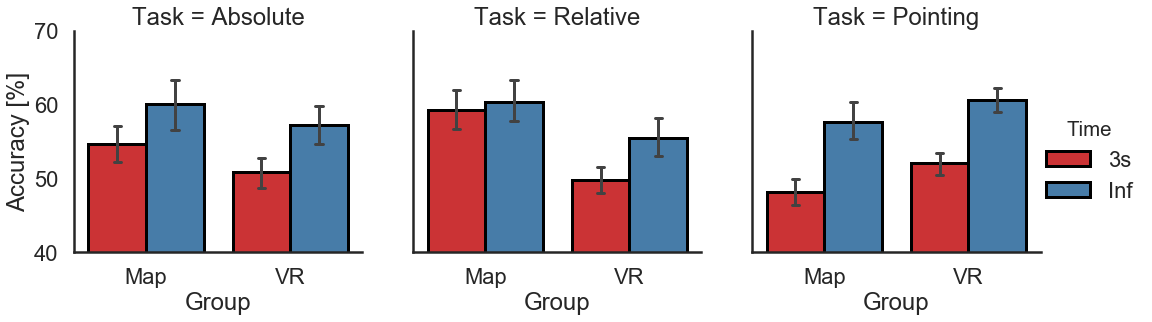

In [28]:
tmpdf = (
    all_data
    .groupby(['Group','Task','Time', 'Subject'])
    .agg({'Accuracy':'mean'})
    .rename(columns={'Accuracy':'Accuracy [%]'})
    .reset_index()
#     .query('Time == "Inf"')
)

display(tmpdf)
sns.set(context = "poster", style="white", palette="Set1", font_scale=1, rc={'figure.figsize':(16,12), "font.family": "sans serif" })
tmpdf['Accuracy [%]'] = tmpdf['Accuracy [%]']*100
# tmpdf['AngularDiff'] = tmpdf['AngularDiff'].astype(int)
# _, ax = plt.subplots(figsize=(16,12))
ax = sns.catplot(data=tmpdf, x='Group', y='Accuracy [%]',hue='Time',col='Task', kind='bar', ci=68,
            capsize=0.05, col_order=['Absolute','Relative','Pointing'],
            edgecolor=(0,0,0),errwidth=3,linewidth=3,
           )
# sns.despine(ax=ax, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
# ax.axhline(50, ls=':', color='k', lw=4)
# ax.set_ylabel('Accuracy [%]')
# ax.set_xlabel('Alignment To North [$^\circ$]')
ax.set(ylim=(40,70))
# ax.legend(title='', loc='upper right', fontsize=25)
# plt.savefig(PLOTS_PATH+'/angleToNorth_accuracy_Inf.png', quality=90)